# IMDB movie review sentiment classification with RNNs

In this notebook, we'll train a recurrent neural network (RNN) for sentiment classification using **Tensorflow** (version $\ge$ 2.0 required) with the **Keras API**. This notebook is largely based on the [Understanding recurrent neural networks](https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/6.2-understanding-recurrent-neural-networks.ipynb) by François Chollet.

First, the needed imports.

In [1]:
%matplotlib inline

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.datasets import imdb
from tensorflow.keras.utils import plot_model

from packaging.version import Version as LV

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

print('Using Tensorflow version: {}, and Keras version: {}.'.format(tf.__version__, tf.keras.__version__))
assert(LV(tf.__version__) >= LV("2.0.0"))

Using Tensorflow version: 2.10.0, and Keras version: 2.10.0.


## IMDB data set

Next we'll load the IMDB data set. First time we may have to download the data, which can take a while.

The dataset contains 50000 movies reviews from the Internet Movie Database, split into 25000 reviews for training and 25000 reviews for testing. Half of the reviews are positive (1) and half are negative (0).

The dataset has already been preprocessed, and each word has been replaced by an integer index.
The reviews are thus represented as varying-length sequences of integers.
(Word indices begin at "3", as "1" is used to mark the start of a review and "2" represents all out-of-vocabulary words. "0" will be used later to pad shorter reviews to a fixed size.)

In [2]:
# number of most-frequent words to use
nb_words = 10000

print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=nb_words)
print('x_train:', x_train.shape)
print('x_test:', x_test.shape)
print()

Loading data...
x_train: (25000,)
x_test: (25000,)



Let's truncate the reviews to `maxlen` first words, and pad any shorter reviews with zeros at the end.

In [3]:
# cut texts after this number of words
maxlen = 80

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

Pad sequences (samples x time)
x_train shape: (25000, 80)
x_test shape: (25000, 80)


The first movie review in the training set:

In [4]:
print("First review in the training set:\n", x_train[0], "length:", len(x_train[0]), "class:", y_train[0])

First review in the training set:
 [  15  256    4    2    7 3766    5  723   36   71   43  530  476   26
  400  317   46    7    4    2 1029   13  104   88    4  381   15  297
   98   32 2071   56   26  141    6  194 7486   18    4  226   22   21
  134  476   26  480    5  144   30 5535   18   51   36   28  224   92
   25  104    4  226   65   16   38 1334   88   12   16  283    5   16
 4472  113  103   32   15   16 5345   19  178   32] length: 80 class: 1


As a sanity check, we can convert the review back to text:

In [5]:
word_index = imdb.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in x_train[0]])
print(decoded_review)

that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you think the whole story was so lovely because it was true and was someone's life after all that was shared with us all


## RNN model

### Initialization

Let's create an RNN model that contains an LSTM layer. The first layer in the network is an *Embedding* layer that converts integer indices to dense vectors of length `embedding_dims`. The output layer contains a single neuron and *sigmoid* non-linearity to match the binary groundtruth (`y_train`). 

Finally, we `compile()` the model, using *binary crossentropy* as the loss function and [*RMSprop*](https://keras.io/optimizers/#rmsprop) as the optimizer.

In [6]:
# model parameters:
embedding_dims = 50
lstm_units = 32

inputs = keras.Input(shape=(None,), dtype="int64")

x = layers.Embedding(input_dim=nb_words, 
                     output_dim=embedding_dims)(inputs)
x = layers.Dropout(0.2)(x)

x = layers.LSTM(lstm_units)(x)

outputs = layers.Dense(1, activation='sigmoid')(x)

model = keras.Model(inputs=inputs, outputs=outputs,
                    name="rnn_model")

# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
print(model.summary())

Model: "rnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 50)          500000    
                                                                 
 dropout (Dropout)           (None, None, 50)          0         
                                                                 
 lstm (LSTM)                 (None, 32)                10624     
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 510,657
Trainable params: 510,657
Non-trainable params: 0
_________________________________________________________________
None


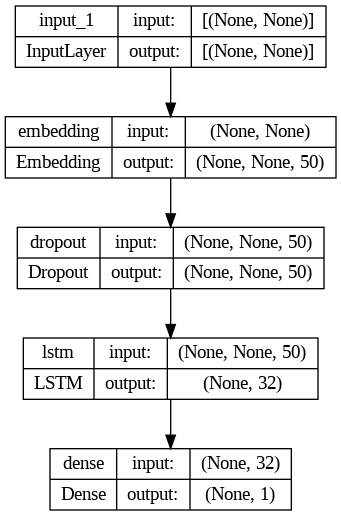

In [7]:
plot_model(model, show_shapes=True)

### Learning

Now we are ready to train our model.  An *epoch* means one pass through the whole training data. Note also that we are using a fraction of the training data as our validation set.

Note that LSTMs are rather slow to train.

In [8]:
%%time
epochs = 5
validation_split = 0.2

history = model.fit(x_train, y_train, batch_size=128,
          epochs=epochs, 
          validation_split=validation_split)

Epoch 1/5
157/157 [==============================] - 13s 66ms/step - loss: 0.4901 - accuracy: 0.7576 - val_loss: 0.3856 - val_accuracy: 0.8356
Epoch 2/5
157/157 [==============================] - 9s 60ms/step - loss: 0.3202 - accuracy: 0.8648 - val_loss: 0.3653 - val_accuracy: 0.8328
Epoch 3/5
157/157 [==============================] - 10s 63ms/step - loss: 0.2737 - accuracy: 0.8902 - val_loss: 0.3658 - val_accuracy: 0.8338
Epoch 4/5
157/157 [==============================] - 9s 57ms/step - loss: 0.2457 - accuracy: 0.9025 - val_loss: 0.3679 - val_accuracy: 0.8380
Epoch 5/5
157/157 [==============================] - 10s 61ms/step - loss: 0.2241 - accuracy: 0.9123 - val_loss: 0.4527 - val_accuracy: 0.8236
CPU times: user 2min 4s, sys: 25.6 s, total: 2min 30s
Wall time: 51 s


Let's plot the data to see how the training progressed. A big gap between training and validation accuracies would suggest overfitting.

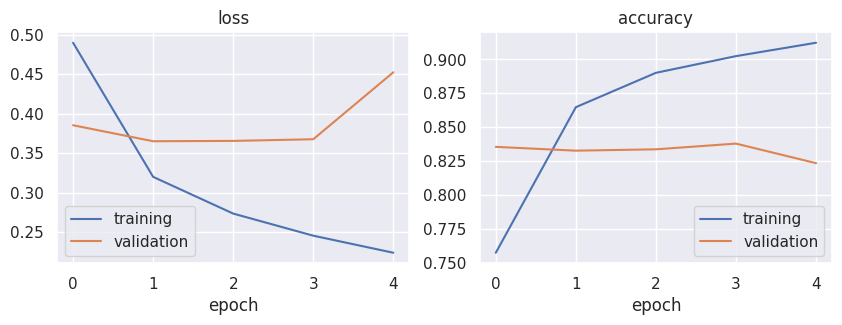

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,3))

ax1.plot(history.epoch,history.history['loss'], label='training')
ax1.plot(history.epoch,history.history['val_loss'], label='validation')
ax1.set_title('loss')
ax1.set_xlabel('epoch')
ax1.legend(loc='best')

ax2.plot(history.epoch,history.history['accuracy'], label='training')
ax2.plot(history.epoch,history.history['val_accuracy'], label='validation')
ax2.set_title('accuracy')
ax2.set_xlabel('epoch')
ax2.legend(loc='best');

### Inference

For a better measure of the quality of the model, let's see the model accuracy for the test data. 

In [10]:
scores = model.evaluate(x_test, y_test, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

782/782 - 9s - loss: 0.4577 - accuracy: 0.8155 - 9s/epoch - 12ms/step
accuracy: 81.55%


We can also use the learned model to predict sentiments for new reviews:

In [11]:
myreviewtext = 'this movie was the worst i have ever seen and the actors were horrible'
#myreviewtext = 'this movie is great and i madly love the plot from beginning to end'

myreview = np.zeros((1,maxlen), dtype=int)
myreview[0, 0] = 1

for i, w in enumerate(myreviewtext.split()):
    if w in word_index and word_index[w]+3<nb_words:
        myreview[0, i+1] = word_index[w]+3
    else:
        print('word not in vocabulary:', w)
        myreview[0, i+1] = 2

print(myreview, "shape:", myreview.shape)

p = model.predict(myreview, batch_size=1) # values close to "0" mean negative, close to "1" positive
print('Predicted sentiment: {}TIVE ({:.4f})'.format("POSI" if p[0,0]>0.5 else "NEGA", p[0,0]))

[[  1  14  20  16   4 249  13  28 126 110   5   4 156  71 527   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0]] shape: (1, 80)
1/1 [==============================] - 1s 556ms/step
Predicted sentiment: NEGATIVE (0.3856)


## Task 1: Two LSTM layers

Create a model with two LSTM layers. Optionally, you can also use [Bidirectional layers](https://keras.io/api/layers/recurrent_layers/bidirectional/).

The code below is missing the model definition. You can copy any suitable layers from the example above.

Loading data...
x_train: (25000,)
x_test: (25000,)

Pad sequences (samples x time)
x_train shape: (25000, 80)
x_test shape: (25000, 80)
Model: "rnn_model_with_two_lstm_layers"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_1 (Embedding)     (None, None, 50)          500000    
                                                                 
 dropout_1 (Dropout)         (None, None, 50)          0         
                                                                 
 lstm_1 (LSTM)               (None, None, 32)          10624     
                                                                 
 lstm_2 (LSTM)               (None, 32)                8320      
                                                                 
 dense_1 (Dense)             (No

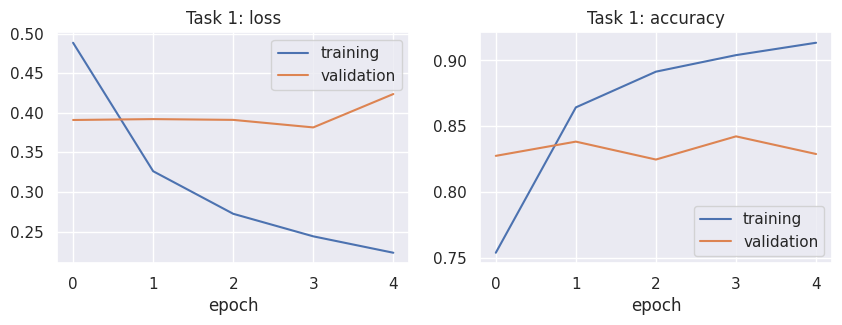

In [12]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.datasets import imdb
import numpy as np
import matplotlib.pyplot as plt

# Load the IMDB dataset
nb_words = 10000

print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=nb_words)
print('x_train:', x_train.shape)
print('x_test:', x_test.shape)
print()

# Pad sequences
maxlen = 80
print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

# Model parameters
embedding_dims = 50
lstm_units = 32

# RNN model with two LSTM layers
ex1_inputs = keras.Input(shape=(None,), dtype="int64")

x = layers.Embedding(input_dim=nb_words, output_dim=embedding_dims)(ex1_inputs)
x = layers.Dropout(0.2)(x)

x = layers.LSTM(lstm_units, return_sequences=True)(x)
x = layers.LSTM(lstm_units)(x)

outputs = layers.Dense(1, activation='sigmoid')(x)

ex1_outputs = outputs

ex1_model = keras.Model(inputs=ex1_inputs, outputs=ex1_outputs, name="rnn_model_with_two_lstm_layers")

ex1_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
print(ex1_model.summary())

# Training
ex1_epochs = 5
ex1_validation_split = 0.2

ex1_history = ex1_model.fit(x_train, y_train, batch_size=128, epochs=ex1_epochs, validation_split=ex1_validation_split)

# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,3))

ax1.plot(ex1_history.epoch, ex1_history.history['loss'], label='training')
ax1.plot(ex1_history.epoch, ex1_history.history['val_loss'], label='validation')
ax1.set_title('Task 1: loss')
ax1.set_xlabel('epoch')
ax1.legend(loc='best')

ax2.plot(ex1_history.epoch, ex1_history.history['accuracy'], label='training')
ax2.plot(ex1_history.epoch, ex1_history.history['val_accuracy'], label='validation')
ax2.set_title('Task 1: accuracy')
ax2.set_xlabel('epoch')
ax2.legend(loc='best')

# Evaluation
ex1_scores = ex1_model.evaluate(x_test, y_test, verbose=2)
print("%s: %.2f%%" % (ex1_model.metrics_names[1], ex1_scores[1]*100))

## Task 2: Model tuning

Modify the model further.  Try to improve the classification accuracy on the test set, or experiment with the effects of different parameters.

To combat overfitting, you can try for example to add dropout. For [LSTMs](https://keras.io/api/layers/recurrent_layers/lstm/), dropout for inputs and the recurrent states can be set with the `dropout` and `recurrent_dropout` arguments:

    x = layers.LSTM(lstm_units, dropout=0.2,
                    recurrent_dropout=0.3)(x)

Another option is use regularization, for example with the `kernel_regularizer` and/or `recurrent_regularizer` arguments:

    x = layers.LSTM(lstm_units, kernel_regularizer='l2',
                    recurrent_regularizer='l2')(x)

Third option is to use early stopping in training. It can be implemented with the [EarlyStopping](https://keras.io/api/callbacks/early_stopping/) callback, for example:

    callbacks = [keras.callbacks.EarlyStopping(
                 monitor="val_loss", patience=1,
                 restore_best_weights=True)]

The callback then needs to be added as an argument to the [`model.fit()`](https://keras.io/api/models/model_training_apis/#fit-method) method.

You can also consult the Keras documentation at https://keras.io/. 

---
*Run this notebook in Google Colaboratory using [this link](https://colab.research.google.com/github/csc-training/intro-to-dl/blob/master/day1/04-tf2-imdb-rnn.ipynb).*

Loading data...
x_train: (25000,)
x_test: (25000,)

Pad sequences (samples x time)
x_train shape: (25000, 80)
x_test shape: (25000, 80)
Model: "rnn_model_with_dropout"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_2 (Embedding)     (None, None, 50)          500000    
                                                                 
 dropout_2 (Dropout)         (None, None, 50)          0         
                                                                 
 lstm_3 (LSTM)               (None, None, 32)          10624     
                                                                 
 lstm_4 (LSTM)               (None, 32)                8320      
                                                                 
 dense_2 (Dense)             (None, 1)  

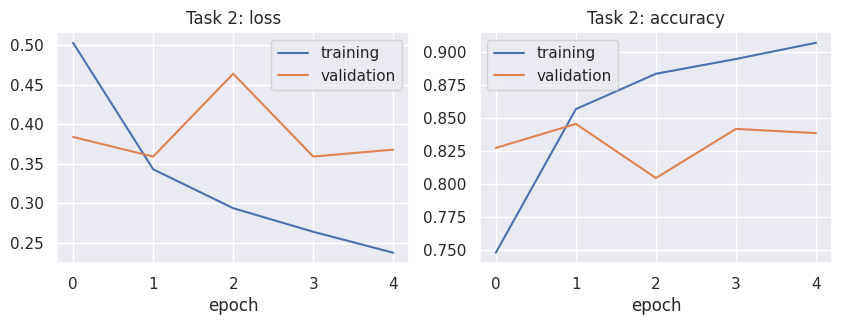

In [13]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.datasets import imdb
import numpy as np
import matplotlib.pyplot as plt

# Load the IMDB dataset
nb_words = 10000

print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=nb_words)
print('x_train:', x_train.shape)
print('x_test:', x_test.shape)
print()

# Pad sequences
maxlen = 80
print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

# Model parameters
embedding_dims = 50
lstm_units = 32

# RNN model with two LSTM layers and dropout
ex2_inputs = keras.Input(shape=(None,), dtype="int64")

x = layers.Embedding(input_dim=nb_words, output_dim=embedding_dims)(ex2_inputs)
x = layers.Dropout(0.2)(x)

x = layers.LSTM(lstm_units, dropout=0.2, recurrent_dropout=0.3, return_sequences=True)(x)
x = layers.LSTM(lstm_units, dropout=0.2, recurrent_dropout=0.3)(x)

outputs = layers.Dense(1, activation='sigmoid')(x)

ex2_outputs = outputs

ex2_model = keras.Model(inputs=ex2_inputs, outputs=ex2_outputs, name="rnn_model_with_dropout")

ex2_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
print(ex2_model.summary())

# Training with early stopping
ex2_epochs = 5
ex2_validation_split = 0.2

callbacks = [keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)]

ex2_history = ex2_model.fit(x_train, y_train, batch_size=128, epochs=ex2_epochs, 
                            validation_split=ex2_validation_split, callbacks=callbacks)

# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,3))

ax1.plot(ex2_history.epoch, ex2_history.history['loss'], label='training')
ax1.plot(ex2_history.epoch, ex2_history.history['val_loss'], label='validation')
ax1.set_title('Task 2: loss')
ax1.set_xlabel('epoch')
ax1.legend(loc='best')

ax2.plot(ex2_history.epoch, ex2_history.history['accuracy'], label='training')
ax2.plot(ex2_history.epoch, ex2_history.history['val_accuracy'], label='validation')
ax2.set_title('Task 2: accuracy')
ax2.set_xlabel('epoch')
ax2.legend(loc='best')

# Evaluation
ex2_scores = ex2_model.evaluate(x_test, y_test, verbose=2)
print("%s: %.2f%%" % (ex2_model.metrics_names[1], ex2_scores[1]*100))